In [62]:
#author - Palash Sethi, palash.sethi@ufl.edu
import numpy as np
import math
import torch
import torch.nn as nn
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import os
import re
from Bio import SeqIO
import json
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch.distributions as dist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import umap
import random
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import Counter
from scipy.stats import pearsonr

In [2]:
bgc_parent_dir = "/orange/juannanzhou/BGC_generation/training_data_subset_T1PKS_T3PKS"
bigcarp_domain_fasta_path = "/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/final_pfams_in_t1t3pks.fasta"
vocab_path = '/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/tokenizer_t1t3pks/vocab_corrected.json'


class SimpleTokenizer:
    def __init__(self, vocab_file):
        with open(vocab_file, 'r') as f:
            vocab = json.load(f)
        self.token_to_id = vocab
        self.id_to_token = {v: k for k, v in vocab.items()}

    def tokens_to_ids(self, tokens):
        return [self.token_to_id.get(token, self.token_to_id['[_UNK]']) for token in tokens]

    def ids_to_tokens(self, token_ids):
        return [self.id_to_token.get(token_id, '[_UNK]') for token_id in token_ids]
    
    def get_vocab(self):
        return self.token_to_id
    
def return_domain_name(tup):
    return 'class_' + tup[0]
    
def process_tokens(tup, add_condition=True,add_cls=False, add_eos=False, seq_len=None):
    bgc_class = 'class_' + tup[0]
    bgc_domain = tup[1].values()
    bgc_domain = [item for i, sublist in enumerate(bgc_domain) for item in (sublist if i == len(bgc_domain) - 1 else sublist + ["[_SEP]"])]
    tokens = []
    if add_condition:
        tokens += [bgc_class]
    if add_cls:
        tokens += ['[_CLS]']
    tokens += bgc_domain
    if add_eos:
        tokens += ['[_EOS]']
    if seq_len:
        tokens += ['[_PAD]'] * (seq_len - len(tokens))
        tokens = tokens[:seq_len]
    if '[_UNK]' in tokens:
        print("UNK found ")
    return tokens

def generate_tokens(tup, type_of_tokens, seq_len):
    """
    # Final Setup for Conditional Seq2Seq VAE:
    # 1. Encoder Input:
    #    ['condition', 'CLS', token1, token2, ..., tokenN] - L+2
    #
    # 2. Latent Variable:
    #    Extract z using the reparameterization trick from the 'CLS' token.
    #
    # 3. Decoder Input (During Training):
    #    ['condition', token1, token2, ..., tokenN, 'EOS'] - L+2
    #    (Internally, z is used for cross attention in the decoder.)
    #
    # 4. Decoder Target:
    #    [token1, token2, ..., tokenN, 'EOS'] - L+1 -- > fix this in a new file altogether you idiot. condition should match to token1.

    """
    if type_of_tokens == 'encoder_input':
        return process_tokens(tup, add_condition=True,add_cls=True, seq_len = seq_len)
    elif type_of_tokens == 'decoder_input':
        return process_tokens(tup, add_condition=True,add_eos=True, seq_len = seq_len)
    elif type_of_tokens == 'decoder_target':
        return process_tokens(tup, add_condition=False,add_eos=True, seq_len = seq_len)
    else:
        raise ValueError("Invalid type_of_tokens. Must be 'encoder_input', 'decoder_input', or 'decoder_target'.")

class BGC_dataset_t1t3pks(Dataset):
    def __init__(self, bgc_pkl_directory, vocab_path, max_seq_len, return_domain = False):
        self.tokenizer = SimpleTokenizer(vocab_path)
        self.seq_len = max_seq_len
        self.data = [os.path.join(bgc_pkl_directory, pkl_file) for pkl_file in os.listdir(bgc_pkl_directory)]
        self.return_domain = return_domain

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        with open(self.data[idx], "rb") as f:
            tup = pickle.load(f)
            encoder_input = torch.tensor(self.tokenizer.tokens_to_ids(generate_tokens(tup, 'encoder_input', self.seq_len)))
            decoder_input = torch.tensor(self.tokenizer.tokens_to_ids(generate_tokens(tup, 'decoder_input', self.seq_len)))
            decoder_target = torch.tensor(self.tokenizer.tokens_to_ids(generate_tokens(tup, 'decoder_target', self.seq_len)))
            if self.return_domain == True:
                return encoder_input, decoder_input, decoder_target, return_domain_name(tup)
        return encoder_input, decoder_input, decoder_target
    
dataset = BGC_dataset_t1t3pks(bgc_parent_dir, vocab_path, 256)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [3]:
def batched_kl_divloss(mu, ln_var):
    #mu and ln_var should be of shape [batch_size, latent_dim]
    return (-0.5 * torch.sum(1 + ln_var - mu.pow(2) - ln_var.exp(), dim=-1)).mean()

def create_masks(encoder_input, decoder_input, pad_token_id=0):
    """
    Generate masks for the encoder and decoder.

    Args:
    - encoder_input: Tensor of shape [batch_size, encoder_seq_len]
    - decoder_input: Tensor of shape [batch_size, decoder_seq_len]
    - pad_token_id: ID of the padding token

    Returns:
    - src_mask: Causal mask for encoder (shape: [encoder_seq_len, encoder_seq_len])
    - src_pad_mask: Padding mask for encoder (shape: [batch_size, encoder_seq_len])
    - tgt_mask: Causal mask for decoder (shape: [decoder_seq_len, decoder_seq_len])
    - tgt_pad_mask: Padding mask for decoder (shape: [decoder_seq_len, decoder_seq_len])
    """
    src_seq_len = encoder_input.shape[1]
    src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool)

    # Encoder padding mask
    src_pad_mask = (encoder_input == pad_token_id)  # Shape: [batch_size, encoder_seq_len]

    # Decoder padding mask
    tgt_pad_mask = (decoder_input == pad_token_id)  # Shape: [batch_size, decoder_seq_len]

    # Decoder causal mask
    seq_len = decoder_input.size(1)
    tgt_mask = torch.triu(torch.ones((seq_len,seq_len), dtype=torch.bool), diagonal=1)  # Shape: [decoder_seq_len, decoder_seq_len]

    return src_mask, src_pad_mask, tgt_mask, tgt_pad_mask

def top_k_sampling(logits, k=10, temperature=1.0):
    """
    Perform top-k sampling on logits of shape [B, num_tokens] to introduce randomness.
    """
    values, indices = torch.topk(logits, k, dim=-1)
    scaled_values = values / temperature
    probabilities = torch.softmax(scaled_values, dim=-1)
    sampled_indices = torch.multinomial(probabilities, 1)  # Shape: [B, 1]
    next_token = indices.gather(1, sampled_indices)  # Shape: [B, 1]
    return next_token

def generate_sequence(model, z, start_token, topk = 10, temperature=1.0, max_length=256, eos_token_id=5, device='cuda', pad_token_id = 0):
    """
    Generates a sequence of tokens using a trained decoder model.

    Returns:
        A list of generated tokens or the decoded sequence if using a tokenizer.
    """
    model.eval()
    generated = torch.tensor([start_token], device=device).unsqueeze(0).unsqueeze(-1)  # Batch size 1
    
    
    for _ in range(max_length - 1):
        with torch.no_grad():
            tgt_mask = torch.triu(torch.ones((generated.shape[1],generated.shape[1]), dtype=torch.bool), diagonal=1).to(device)  # Shape: [decoder_seq_len, decoder_seq_len]
            tgt_pad_mask = (generated == pad_token_id).unsqueeze(0).to(device)
            outputs = model.decode(z.to(device), generated, tgt_mask, tgt_pad_mask)
            next_token_logits = outputs[:, -1, :]  # Take logits of the last token
            next_token = top_k_sampling(next_token_logits, k=topk, temperature = temperature)

            generated = torch.cat((generated, next_token.unsqueeze(-1)), dim=1)
            
            if eos_token_id is not None:
                if next_token.item() == eos_token_id:
                    break

    return generated.squeeze().tolist(), next_token_logits

def initialise_embeds(vocab_size, embedding_dim = 1280, load_esm_embeds = True):
    special_token_size = 8
    if load_esm_embeds:
        embeds = torch.load("/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/esm1b_pfam_embs_t1t3pks.pt")
        pre_saved_embeddings = (embeds - embeds.mean(dim=0)) / embeds.std(dim=0) #(vocab_size - 8, 1280)
        weights = torch.cat([torch.randn(special_token_size, embedding_dim), pre_saved_embeddings], dim=0)
        values_to_be_not_updated = [i for i in range(8,vocab_size)]
    else:
        weights = torch.randn(vocab_size, embedding_dim)
        values_to_be_not_updated = []
    embedding = nn.Embedding.from_pretrained(embeddings=weights,freeze=False, padding_idx = 0)
    return embedding, values_to_be_not_updated

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 256):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]
        

class cVAE(nn.Module):
    def __init__(self, num_tokens: int, latent_dim: int= 256,
                 d_model: int= 512, d_ff: int= 2048, num_layers: int= 6, nhead: int= 8, 
                 activation: str= 'gelu', dropout: float= 0.1) -> None:
        super().__init__()
        assert activation in ['relu', 'gelu']
        self.d_model = d_model
        self.latent_dim = latent_dim
        self.dropout = dropout
        self.esm_dim = 1280

        self.embeddings, self.values_to_be_not_updated = initialise_embeds(num_tokens, self.esm_dim)   #(B, num_tokens, esm_dimension = 1280)
        self.embeddings.weight.register_hook(self.set_grads_to_zero_hook)
        self.fc_esmec = nn.Sequential(nn.Linear(self.esm_dim, self.d_model))  
        self.fc_esmdec = nn.Sequential(nn.Linear(self.esm_dim, self.d_model))
        self.PE = PositionalEncoding(d_model = d_model)

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model= d_model, nhead= nhead, dim_feedforward= d_ff,
                                                   dropout= self.dropout, activation= activation, batch_first= True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_layers)

        # vae
        self.fc_vae = nn.Sequential(nn.Linear(d_model, latent_dim), 
                                    nn.Linear(latent_dim, 2*latent_dim))

        # transformer decoder
        self.fc_memory = nn.Linear(latent_dim, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model= d_model, nhead= nhead, dim_feedforward= d_ff,
                                                   dropout= self.dropout, activation= activation, batch_first= True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_layers)
        self.fc_dec_ntokens = nn.Linear(d_model, num_tokens)

        # for decode smiles
        self.labels = None

    def forward(self, bgc_src: torch.Tensor, bgc_tgt: torch.Tensor, src_mask: torch.Tensor= None, 
                src_pad_mask: torch.Tensor= None, tgt_mask: torch.Tensor= None, 
                tgt_pad_mask: torch.Tensor= None, condition: torch.Tensor= None):
        """
        encode and decode. 
        bgc_src only has [cls] in front, bgc_tgt has [eos] in back. both have condition pre-appended
        """

        z, mu, ln_var = self.encode(bgc_src, src_mask, src_pad_mask)
        output = self.decode(z, bgc_tgt, tgt_mask, tgt_pad_mask)

        return z, mu, ln_var, output


    def encode(self, bgc: torch.Tensor, src_mask: torch.Tensor= None, src_pad_mask: torch.Tensor= None):
        """
        bgc: shape= (Batch_size, Length+2, 1) #+2 comes from condition and [cls] token added in the beginning before domains start (L includes [_SEP])
        src_mask: source mask for masked attention, shape= (Length+num_conditions+1, Length+num_conditions+1)
        src_pad_mask: shape = (Batch_size, Length+num_conditions+1)
        """
        src = self.embeddings(bgc.squeeze(-1))                  # (B, L+2, esm_dim)
        src = self.fc_esmec(src)                                # (B, L+2, d_model)
        src = self.PE(src)                                      # (B, L+2, d_model), * math.sqrt(self.d_model)?

        out = self.encoder(src, mask= src_mask, src_key_padding_mask= src_pad_mask) # (B, L+2, d_model)
        out = out[:, 1, :].squeeze(1) #taking on the encoder embeddings of [cls] token present at index 1 in the encoder output

        # vae
        mu, ln_var = self.fc_vae(out).chunk(2, dim= -1)
        z = self.reparameterization_trick(mu, ln_var)               # (B, latent_dim)

        return z, mu, ln_var
    

    def decode(self, z: torch.Tensor, bgc: torch.Tensor,
               tgt_mask: torch.Tensor= None, tgt_pad_mask: torch.Tensor= None):
        """
        z: encoder output. shape= (Batch_size, latent_dim)
        bgc: shape= (Batch_size, Length+2, 1) - due to condition and [eos]
        tgt_mask: target mask for masked attention, shape= (Length+1, Length+1)
        tgt_pad_mask: target mask for padding, shape= (Batch_size, Length+1)

        output: logits of label preditions, shape= (Batch_size, Length+1, num_labels)
        """

        # latent variable to memory
        # print(bgc)
        memory = self.fc_memory(z).unsqueeze(1)                     # (B, 1, d_model)
        
        tgt = self.embeddings(bgc.squeeze(-1))                      # (B, L+2, esm_dim)
        tgt = self.fc_esmdec(tgt)                                   # (B, L+2, d_model)
        tgt = self.PE(tgt)                                          # (B, L+2, d_model)

        # transformer decoding
        out = self.decoder(tgt, memory, tgt_mask= tgt_mask, tgt_key_padding_mask= tgt_pad_mask)  # (B, L+2, d_model)
        #above, memory is sent explicitly because it is used by decoder for cross attention internally, most probably, hence, mem cannot come before target
        out = self.fc_dec_ntokens(out)                               # (B, L+1, num_tokens) #logits are returned

        return out

    def reparameterization_trick(self, mu, ln_var):
        eps = torch.randn_like(mu)
        z = mu + torch.exp(ln_var / 2) * eps if self.training else mu

        return z
    
    def set_grads_to_zero_hook(self, grad):
        grad = grad.clone()
        grad[self.values_to_be_not_updated] = 0.
        return grad

In [4]:
def plot_embeddings(matrix, labels, cmap='coolwarm'):
    try:
        matrix = np.concatenate(matrix)
    except:
        matrix = matrix
    if isinstance(labels[0], tuple):
        labels = [item for tup in labels for item in tup]
    unique_labels = list(set(labels))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    color_labels = [label_to_int[label] for label in labels]

    pca = PCA(n_components=2).fit_transform(matrix)
    umap_emb = umap.UMAP(n_components=2).fit_transform(matrix)
    tsne_emb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(matrix)

    # PCA plot
    scatter = plt.scatter(pca[:, 0], pca[:, 1], c=color_labels, cmap=cmap, alpha=0.7, edgecolors='k', s=50)
    handles, _ = scatter.legend_elements()
    legend_labels = [unique_labels[i] for i in range(len(handles))]
    legend = plt.legend(handles, legend_labels, title="Class Labels", fontsize=10)
    plt.gca().add_artist(legend)
    plt.title("PCA Projection", fontsize=14, weight='bold')
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.tight_layout()
    plt.show()

    # UMAP plot
    scatter = plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=color_labels, cmap=cmap, alpha=0.7, edgecolors='k', s=50)
    handles, _ = scatter.legend_elements()
    legend_labels = [unique_labels[i] for i in range(len(handles))]
    legend = plt.legend(handles, legend_labels, title="Class Labels", fontsize=10)
    plt.gca().add_artist(legend)
    plt.title("UMAP Projection", fontsize=14, weight='bold')
    plt.xlabel("UMAP Dimension 1", fontsize=12)
    plt.ylabel("UMAP Dimension 2", fontsize=12)
    plt.tight_layout()
    plt.show()

    # t-SNE plot
    scatter = plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=color_labels, cmap=cmap, alpha=0.7, edgecolors='k', s=50)
    handles, _ = scatter.legend_elements()
    legend_labels = [unique_labels[i] for i in range(len(handles))]
    legend = plt.legend(handles, legend_labels, title="Class Labels", loc='upper right', fontsize=10)
    plt.gca().add_artist(legend)
    plt.title("t-SNE Projection", fontsize=14, weight='bold')
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.tight_layout()
    plt.show()



def eval_cVAE(dataloader, model, lambda_lrecc = 1.0, lambda_lkl = 1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss_reconstruction = nn.CrossEntropyLoss()
    z_training_data = []
    z_dname = []
    losses = {'l_rec':[], 'l_kl': [], 'total': []}
    model.to(device)
    model.eval()
    with torch.no_grad():
        for ei, di, dt, dn in dataloader:
            ei, di, dt = ei.to(device), di.to(device), dt.to(device)
            src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = create_masks(ei, di)
            src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = src_mask.to(device), src_pad_mask.to(device), tgt_mask.to(device), tgt_pad_mask.to(device)
            z, mu, ln_var, output = model(ei, di, src_mask, src_pad_mask, tgt_mask, tgt_pad_mask)
            z_training_data.append(z.cpu().numpy())
            z_dname.append(dn)
            l_rec = loss_reconstruction(output.view(-1, output.size(-1)), dt.view(-1))
            l_kl = batched_kl_divloss(mu, ln_var)
            loss = lambda_lrecc*l_rec + lambda_lrecc*l_kl
            losses['l_rec'].append(l_rec.item())
            losses['l_kl'].append(l_kl.item())
            losses['total'].append(loss.item())
            
    print('Test Loss: ',np.mean(losses['total']))
    return z_training_data, z_dname, losses

def train_cVAE_no_eval(dataloader, learning_rate, num_epochs, tokenizer, model, lambda_lrecc = 1.0, lambda_lkl = 1.0):
    loss_reconstruction = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = {'l_rec':[], 'l_kl': [], 'total': []}

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for ei, di, dt in dataloader:
            ei, di, dt = ei.to(device), di.to(device), dt.to(device)
            src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = create_masks(ei, di)
            src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = src_mask.to(device), src_pad_mask.to(device), tgt_mask.to(device), tgt_pad_mask.to(device)

            optimizer.zero_grad()

            z, mu, ln_var, output = model(ei, di, src_mask, src_pad_mask, tgt_mask, tgt_pad_mask)
            l_rec = loss_reconstruction(output.view(-1, output.size(-1)), dt.view(-1))
            l_kl = batched_kl_divloss(mu, ln_var)
            loss = lambda_lrecc*l_rec + lambda_lrecc*l_kl
            losses['l_rec'].append(l_rec.item())
            losses['l_kl'].append(l_kl.item())
            losses['total'].append(loss.item())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
    return model, losses

def train_cVAE(dataloader, learning_rate, num_epochs, tokenizer, model, eval_dataloader, lambda_lrecc=1.0, lambda_lkl=1.0):
    loss_reconstruction = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = {'l_rec': [], 'l_kl': [], 'total': []}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for ei, di, dt in dataloader:
            ei, di, dt = ei.to(device), di.to(device), dt.to(device)
            src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = create_masks(ei, di)
            src_mask, src_pad_mask, tgt_mask, tgt_pad_mask = src_mask.to(device), src_pad_mask.to(device), tgt_mask.to(device), tgt_pad_mask.to(device)

            optimizer.zero_grad()

            z, mu, ln_var, output = model(ei, di, src_mask, src_pad_mask, tgt_mask, tgt_pad_mask)
            l_rec = loss_reconstruction(output.view(-1, output.size(-1)), dt.view(-1))
            l_kl = batched_kl_divloss(mu, ln_var)
            loss = lambda_lrecc * l_rec + lambda_lkl * l_kl
            losses['l_rec'].append(l_rec.item())
            losses['l_kl'].append(l_kl.item())
            losses['total'].append(loss.item())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

        # Run evaluation every 3 epochs
        if (epoch + 1) % 3 == 0:
            # print(f"Running evaluation after Epoch {epoch + 1}...")
            z_training_data, z_dname, eval_losses = eval_cVAE(eval_dataloader, model, lambda_lrecc, lambda_lkl)
            print(f"Evaluation Loss: {np.mean(eval_losses['total']):.4f}")

    return model, losses

def remove_extra_tokens(ei):
    tok = [i for i in range(8)]
    filtered_tensor = [row[~torch.isin(row, torch.tensor(tok))] for row in ei]
    return filtered_tensor

def get_ESM_embeddings(dataloader, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    esm_embeddings = []
    z_dname = []
    model.eval()
    with torch.no_grad():
        for ei, di, dt, dn in dataloader:
            ei = remove_extra_tokens(ei)
            z_dname.append(dn)
            for ei_ in ei:
                ei_= ei_.to(device)
                esm_embeddings.append(model.embeddings(ei_).mean(0).cpu())
    return torch.stack(esm_embeddings), z_dname

def get_ESM_embeddings_for_synthetic(tokenizer, token_ids_list, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    esm_embeddings = []
    z_dname = []
    model.eval()
    with torch.no_grad():
        for token_ids in token_ids_list:
            # print(token_ids)
            dname = 'generated_'+tokenizer.ids_to_tokens([token_ids[0]])[0]
            # print(dname)
            ei = remove_extra_tokens(torch.tensor(token_ids).unsqueeze(0))[0].to(device)
            # print(ei)
            esm_embeddings.append(model.embeddings(ei).mean(0).cpu())
            z_dname.append(dname)
    return torch.stack(esm_embeddings), z_dname

def train_logistic_regression(embedding, labels):
    label_map = {label: idx for idx, label in enumerate(set(labels))}
    labels = torch.tensor([label_map[label] for label in labels])
    
    try:
        embedding, labels = embedding.cpu().numpy(), labels.cpu().numpy()
    except:
        embedding, labels = embedding, labels

    X_train, X_test, y_train, y_test = train_test_split(
        embedding, labels, test_size=0.2, random_state=42, stratify=labels
    )

    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, proba)
    acc = accuracy_score(y_test, preds)
    fpr, tpr, _ = roc_curve(y_test, proba)

    plt.plot(fpr, tpr, label=f"AUROC: {auroc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.title("AUROC Curve (Test Data)")
    plt.show()

    return auroc, acc, model

def train_and_test_logistic_regression(embedding, labels, train_labels, validate_labels):
    label_map = {label: idx for idx, label in enumerate(set(labels))}
    labels = torch.tensor([label_map[label] for label in labels])
    
    try:
        embedding, labels = embedding.cpu().numpy(), labels.cpu().numpy()
    except:
        embedding, labels = embedding, labels

    # Filter training data based on train_labels
    train_mask = np.isin(labels, [label_map[label] for label in train_labels])
    X_train, y_train = embedding[train_mask], labels[train_mask]

    # Train the logistic regression model
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

    # Filter validation data based on validate_labels
    validate_mask = np.isin(labels, [label_map[label] for label in validate_labels])
    X_validate = embedding[validate_mask]

    # Predict classes for the validation data
    validate_preds = model.predict(X_validate)

    # Calculate percentage of rows predicted for each class in train_labels
    unique_train_labels = [label_map[label] for label in train_labels]
    class_counts = {label: np.sum(validate_preds == label) for label in unique_train_labels}
    total = len(validate_preds)
    percentages = {label: (count / total) * 100 for label, count in class_counts.items()}

    # Print percentages
    print("Percentages of rows predicted for each train label:")
    for label, percent in percentages.items():
        original_label = list(label_map.keys())[list(label_map.values()).index(label)]
        print(f"Class '{original_label}': {percent:.2f}%")

    return model


def filter_matrix_labels(matrix, labels, allowed_labels):
    matrix, labels = np.array(matrix), np.array(labels)
    mask = np.isin(labels, allowed_labels)
    return matrix[mask], labels[mask]

In [5]:
dataset_with_domain = BGC_dataset_t1t3pks(bgc_parent_dir, vocab_path, 256, return_domain=True)
labels = [data[3] for data in dataset_with_domain]  
train_indices, test_indices = train_test_split(
    range(len(dataset_with_domain)),
    test_size=0.05, 
    stratify=labels,
    random_state=42
)
train_dataset = BGC_dataset_t1t3pks(bgc_parent_dir, vocab_path, 256, return_domain=False)
train_dataloader = DataLoader(Subset(train_dataset, train_indices), batch_size=10, shuffle=True)
test_dataset = BGC_dataset_t1t3pks(bgc_parent_dir, vocab_path, 256, return_domain=True)
test_dataloader = DataLoader(Subset(test_dataset, test_indices), batch_size=10, shuffle=False)

learning_rate = 1e-4
num_epochs = 200
tokenizer = SimpleTokenizer(vocab_path)
model = cVAE(len(tokenizer.get_vocab()), num_layers = 1, nhead = 8)
model, losses = train_cVAE(train_dataloader, learning_rate, num_epochs, tokenizer, model, test_dataloader)

Epoch [1/200], Loss: 2.3237
Epoch [2/200], Loss: 1.3407
Epoch [3/200], Loss: 1.2214


/apps/pytorch/2.0.1b/lib/python3.11/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/apps/pytorch/2.0.1b/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Test Loss:  1.2071894515644421
Evaluation Loss: 1.2072
Epoch [4/200], Loss: 1.1554
Epoch [5/200], Loss: 1.1082
Epoch [6/200], Loss: 1.0699
Test Loss:  1.095574606548656
Evaluation Loss: 1.0956
Epoch [7/200], Loss: 1.0343
Epoch [8/200], Loss: 1.0036
Epoch [9/200], Loss: 0.9747
Test Loss:  1.0377316366542468
Evaluation Loss: 1.0377
Epoch [10/200], Loss: 0.9479
Epoch [11/200], Loss: 0.9221
Epoch [12/200], Loss: 0.8991
Test Loss:  0.9952376105568626
Evaluation Loss: 0.9952
Epoch [13/200], Loss: 0.8758
Epoch [14/200], Loss: 0.8542
Epoch [15/200], Loss: 0.8332
Test Loss:  0.9667099009860646
Evaluation Loss: 0.9667
Epoch [16/200], Loss: 0.8134
Epoch [17/200], Loss: 0.7931
Epoch [18/200], Loss: 0.7740
Test Loss:  0.9495125629685142
Evaluation Loss: 0.9495
Epoch [19/200], Loss: 0.7545
Epoch [20/200], Loss: 0.7368
Epoch [21/200], Loss: 0.7184
Test Loss:  0.9387641603296454
Evaluation Loss: 0.9388
Epoch [22/200], Loss: 0.7011
Epoch [23/200], Loss: 0.6845
Epoch [24/200], Loss: 0.6681
Test Loss:  0

In [6]:
z_test_data, z_dname, losses = eval_cVAE(test_dataloader, model)

Test Loss:  1.2030698602849788


In [7]:
dataset = BGC_dataset_t1t3pks(bgc_parent_dir, vocab_path, 256, return_domain=True)
train_dataloader = DataLoader(Subset(dataset, train_indices), batch_size=10, shuffle=True)
esm_embeds_for_train_data, labels_for_train_data = get_ESM_embeddings(train_dataloader, model)
flat_labels_for_train_data = [item for tup in labels_for_train_data for item in tup]

In [8]:
dataset = BGC_dataset_t1t3pks(bgc_parent_dir, vocab_path, 256, return_domain=True)
test_dataloader = DataLoader(Subset(dataset, test_indices), batch_size=10, shuffle=True)
esm_embeds_for_test_data, labels_for_test_data = get_ESM_embeddings(test_dataloader, model)
flat_labels_for_test_data = [item for tup in labels_for_test_data for item in tup]

In [231]:
ld = 256
multinorm = dist.MultivariateNormal(torch.zeros(ld), torch.ones(ld) * torch.eye(ld))
n_samples = 500
generated_seqeunces = []
for _ in range(n_samples):
    z_sample = multinorm.sample((1,))
    start_token = random.choice([6, 7]) #"class_T3PKS"
    max_length = 256
    topk=10
    t = 3
    gs, ntl=(generate_sequence(model, z_sample, start_token, topk=10, temperature=t, max_length=256))
    generated_seqeunces.append(gs)
    
esm_embeds_for_synthetic_data, flat_labels_for_synthetic_data = get_ESM_embeddings_for_synthetic(tokenizer, generated_seqeunces, model)

/apps/pytorch/2.0.1b/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


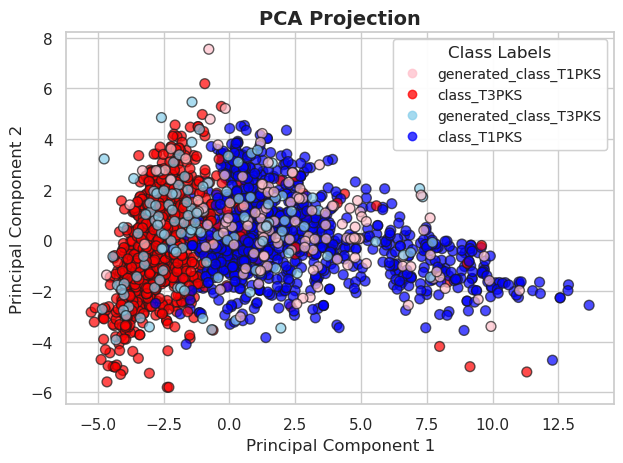

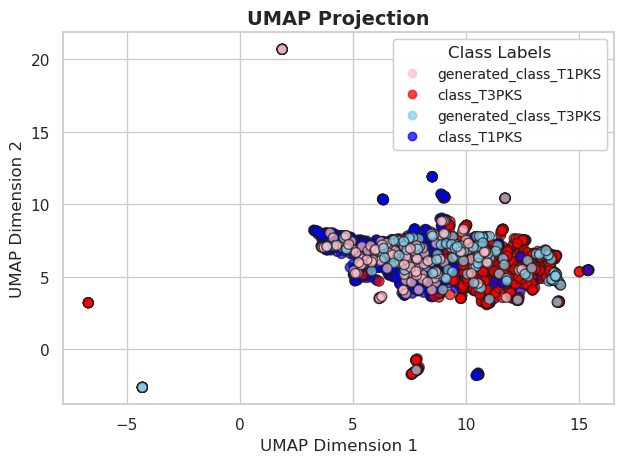

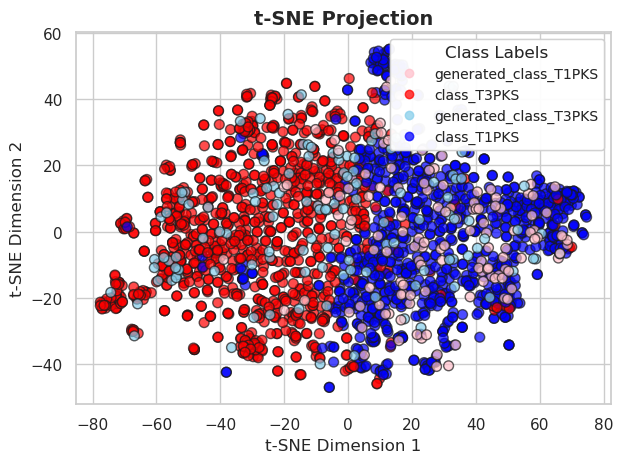

In [224]:
plot_embeddings(torch.concat([esm_embeds_for_train_data, esm_embeds_for_synthetic_data],dim=0), flat_labels_for_train_data+flat_labels_for_synthetic_data, ListedColormap(['pink', 'red', 'skyblue', 'blue']))

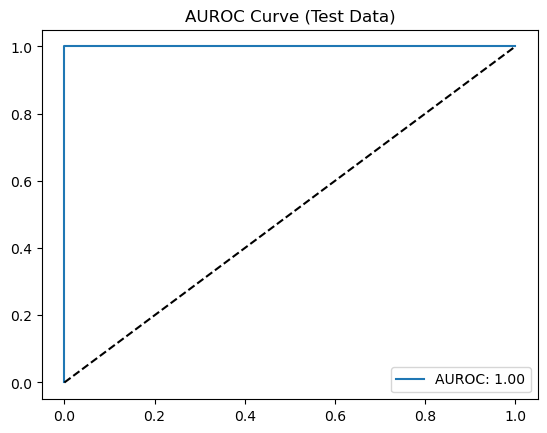

In [28]:
train_syn_emb_for_dis = torch.concat([esm_embeds_for_test_data, esm_embeds_for_synthetic_data],dim=0)
train_syn_emb_for_dis, train_syn_labels_for_dis = filter_matrix_labels(train_syn_emb_for_dis,\
                                                                flat_labels_for_test_data+flat_labels_for_synthetic_data, ['class_T1PKS', 'class_T3PKS'])
auroc, acc,_ = train_logistic_regression(train_syn_emb_for_dis, train_syn_labels_for_dis)

In [ ]:
train_syn_emb_for_dis = torch.concat([esm_embeds_for_train_data, esm_embeds_for_synthetic_data],dim=0)
train_syn_emb_for_dis, train_syn_labels_for_dis = filter_matrix_labels(train_syn_emb_for_dis,\
                                                                flat_labels_for_train_data+flat_labels_for_synthetic_data, ['class_T3PKS', 'generated_class_T3PKS'])
auroc, acc, lr_model = train_logistic_regression(train_syn_emb_for_dis, train_syn_labels_for_dis)

In [225]:
train_syn_emb_for_dis = torch.concat([esm_embeds_for_train_data, esm_embeds_for_synthetic_data],dim=0)
train_syn_emb_for_dis, train_syn_labels_for_dis = filter_matrix_labels(train_syn_emb_for_dis,\
                                                                flat_labels_for_train_data+flat_labels_for_synthetic_data, ['class_T3PKS', 'class_T1PKS', 'generated_class_T3PKS', 'generated_class_T1PKS'])
lr_model = train_and_test_logistic_regression(train_syn_emb_for_dis, train_syn_labels_for_dis, ['class_T3PKS', 'class_T1PKS'],['generated_class_T3PKS'])

Percentages of rows predicted for each train label:
Class 'class_T3PKS': 69.17%
Class 'class_T1PKS': 30.83%


In [226]:
train_syn_emb_for_dis = torch.concat([esm_embeds_for_train_data, esm_embeds_for_synthetic_data],dim=0)
train_syn_emb_for_dis, train_syn_labels_for_dis = filter_matrix_labels(train_syn_emb_for_dis,\
                                                                flat_labels_for_train_data+flat_labels_for_synthetic_data, ['class_T3PKS', 'class_T1PKS', 'generated_class_T3PKS', 'generated_class_T1PKS'])
lr_model = train_and_test_logistic_regression(train_syn_emb_for_dis, train_syn_labels_for_dis, ['class_T3PKS', 'class_T1PKS'],['generated_class_T1PKS'])

Percentages of rows predicted for each train label:
Class 'class_T3PKS': 12.31%
Class 'class_T1PKS': 87.69%


In [228]:
def lda_visualization(embedding, labels):
    lda = LinearDiscriminantAnalysis(n_components=2)
    label_map = {label: idx for idx, label in enumerate(set(labels))}
    numeric_labels = [label_map[label] for label in labels]
    print(len(set(numeric_labels)))
    reduced = lda.fit_transform(embedding, numeric_labels)
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=numeric_labels, cmap='coolwarm', alpha=0.3)
    handles, _ = scatter.legend_elements()
    legend_labels = [label for label, idx in label_map.items()]
    plt.legend(handles, legend_labels, title="Classes", fontsize=10)
    plt.title("LDA Projection")
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.show()

In [354]:
lda_visualization(train_syn_emb_for_dis, train_syn_labels_for_dis)

2


ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

4


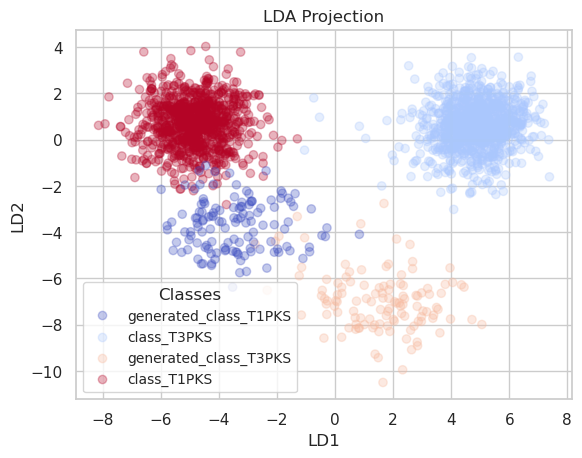

In [230]:
train_syn_emb_for_dis = torch.concat([esm_embeds_for_train_data, esm_embeds_for_synthetic_data],dim=0)
train_syn_emb_for_dis, train_syn_labels_for_dis = filter_matrix_labels(train_syn_emb_for_dis,\
                                                                flat_labels_for_train_data+flat_labels_for_synthetic_data, ['class_T3PKS', 'class_T1PKS', 'generated_class_T1PKS', 'generated_class_T3PKS'])
lda_visualization(train_syn_emb_for_dis, train_syn_labels_for_dis)

In [16]:
def get_all_tokens_ids_for_train(dataloader):
    token_ids_flattened = []
    z_dname_vs_domains = {}
    for ei, di, dt, dn in dataloader:
        ei = remove_extra_tokens(ei)
        for ei_, dn_ in zip(ei, list(dn)):
            if dn_ not in z_dname_vs_domains:
                z_dname_vs_domains[dn_] = []
            z_dname_vs_domains[dn_].append(ei_)
    return z_dname_vs_domains


In [31]:
def get_all_tokens_ids_for_synthetic(tokenizer, token_ids_list):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    esm_embeddings = []
    z_dname_vs_domains = {}
    for token_ids in token_ids_list:
        dname = 'generated_'+tokenizer.ids_to_tokens([token_ids[0]])[0]
        if dname not in z_dname_vs_domains:
            z_dname_vs_domains[dname] = []
        ei = remove_extra_tokens(torch.tensor(token_ids).unsqueeze(0))[0]
        z_dname_vs_domains[dname].append(ei)
    return z_dname_vs_domains

In [17]:
z_dict=get_all_tokens_ids_for_train(train_dataloader)

In [32]:
syn_z_dict = get_all_tokens_ids_for_synthetic(tokenizer, generated_seqeunces)

In [44]:
def save_frequency_lists(z_dict, output_dir, all_elements=range(8, 5454), save=True):
    os.makedirs(output_dir, exist_ok=True)
    result = {}
    for key, value in z_dict.items():
        l_o_l = [tensor.tolist() for tensor in z_dict[key]]
        flat_l_o_l = [item for sublist in l_o_l for item in sublist]
        frequency_list = Counter(flat_l_o_l)
        total_count = sum(frequency_list.values())
        for element in all_elements:
            frequency_list[element] = frequency_list.get(element, 0)
        normalized_frequency_list = {item: count / total_count for item, count in frequency_list.items()}
        sorted_normalized_frequency_list = sorted(normalized_frequency_list.items(), key=lambda x: x[0])
        result[key] = sorted_normalized_frequency_list
        if save:
            file_path = os.path.join(output_dir, f"{key}.json")
            with open(file_path, "w") as f:
                json.dump(sorted_normalized_frequency_list, f, indent=4)
            print(f"Saved frequency list for '{key}' to: {file_path}")
    return result


In [45]:
def save_pairwise_probabilities(z_dict, output_dir, all_elements=range(8, 5454), save=True):
    os.makedirs(output_dir, exist_ok=True)
    result = {}
    for key, value in z_dict.items():
        l_o_l = [tensor.tolist() for tensor in z_dict[key]]
        pairwise_counts = defaultdict(int)
        total_pairs = 0
        for sublist in l_o_l:
            for pair in combinations(sublist, 2):
                pairwise_counts[tuple(sorted(pair))] += 1
                total_pairs += 1
        pairwise_probabilities = {
            str(pair): count / total_pairs for pair, count in pairwise_counts.items()
        }
        pairwise_probabilities = dict(sorted(pairwise_probabilities.items(), key=lambda x: x[1], reverse=True))
        result[key] = pairwise_probabilities
        if save:
            file_path = os.path.join(output_dir, f"{key}_pairwise_probabilities.json")
            with open(file_path, "w") as f:
                json.dump(pairwise_probabilities, f, indent=4)
            print(f"Saved pairwise probabilities for '{key}' to: {file_path}")
    return result


In [47]:
o_dr = "/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/frequency_lists_t1t3pks"
train_frequency = save_frequency_lists(z_dict, o_dr)
o_dr = "/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/pairwise_prob_t1t3pks"
train_pairwise_frequency = save_pairwise_probabilities(z_dict, o_dr)

Saved frequency list for 'class_T1PKS' to: /blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/frequency_lists_t1t3pks/class_T1PKS.json
Saved frequency list for 'class_T3PKS' to: /blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/frequency_lists_t1t3pks/class_T3PKS.json
Saved pairwise probabilities for 'class_T1PKS' to: /blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/pairwise_prob_t1t3pks/class_T1PKS_pairwise_probabilities.json
Saved pairwise probabilities for 'class_T3PKS' to: /blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/pairwise_prob_t1t3pks/class_T3PKS_pairwise_probabilities.json


In [54]:
o_dr = "/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/frequency_lists_t1t3pks"
syn_frequency = save_frequency_lists(syn_z_dict, o_dr, save=False)
o_dr = "/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/pairwise_prob_t1t3pks"
syn_pairwise_frequency = save_pairwise_probabilities(syn_z_dict, o_dr, save=False)

In [211]:
def intersect_and_pearson_pairwise(dict1, dict2, plot=False):
    intersecting_keys = set(dict1.keys()).intersection(dict2.keys())
    dict1_values = [dict1[key] for key in intersecting_keys]
    dict2_values = [dict2[key] for key in intersecting_keys]
    correlation, _ = pearsonr(dict1_values, dict2_values)
    
    if plot:
        plt.scatter(dict1_values, dict2_values, alpha=0.7)
        plt.title(f"Scatter Plot\nPearson r: {correlation:.2f}")
        plt.xlabel("Pairwise frequencies from training data")
        plt.ylabel("Pairwise frequencies from generated data")
        plt.grid(True)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(4e-5, None)
        plt.ylim(4e-5, None)
        plt.show()
    
    return len(intersecting_keys), correlation



def intersect_and_pearson_individual(list1, list2, plot=False):
    list1_values = [key[1] for key in list1]
    list2_values = [key[1] for key in list2]
    correlation, _ = pearsonr(list1_values, list2_values)
    
    if plot:
        # Transform for log scale
        log_list1_values = np.log10(np.array(list1_values) + 1e-8)
        log_list2_values = np.log10(np.array(list2_values) + 1e-8)
        
        # Create a DataFrame for Seaborn
        import pandas as pd
        data = pd.DataFrame({
            "log_list1_values": log_list1_values,
            "log_list2_values": log_list2_values
        })
        
        # Generate the jointplot
        sns.set_theme(style="whitegrid")
        g = sns.jointplot(
            data=data,
            x="log_list1_values",
            y="log_list2_values",
            # kind='hex',
            # cmap="binary",
            # color="flair",
            # cmap=sns.cubehelix_palette(start=2, rot=0, reverse=True, as_cmap=True),
            marginal_kws=dict(bins=30, fill=True)
        )
        
        # Add the Pearson correlation to the plot
        g.fig.suptitle(f"Joint Density Plot\nPearson r: {correlation:.2f}", fontsize=14)
        g.ax_joint.set_xlabel("log10(Pairwise frequencies from training data)", fontsize=12)
        g.ax_joint.set_ylabel("log10(Pairwise frequencies from generated data)", fontsize=12)
        g.ax_joint.grid(True, linestyle="--", alpha=0.7)
        plt.subplots_adjust(top=0.9)  # Adjust title position
        plt.xlim(-5, None)
        plt.ylim(-5, None)
        plt.show()
    
    return correlation





In [60]:
print(train_frequency['class_T1PKS'][:5],syn_frequency['generated_class_T1PKS'][:5])

[(8, 3.201895522149112e-05), (9, 0.0), (10, 0.0003682179850471479), (11, 0.0008645117909802603), (12, 0.0)] [(8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0010623981868404279), (12, 0.0)]


In [82]:
len(train_pairwise_frequency['class_T3PKS'])

392666

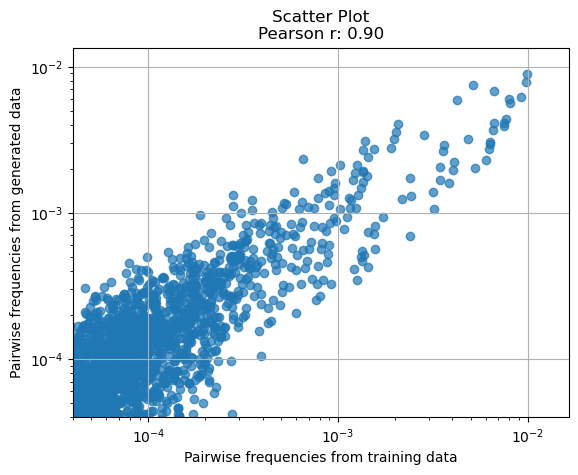

(51652, 0.9015553909529626)

In [130]:
intersect_and_pearson_pairwise(train_pairwise_frequency['class_T1PKS'],syn_pairwise_frequency['generated_class_T1PKS'], True)

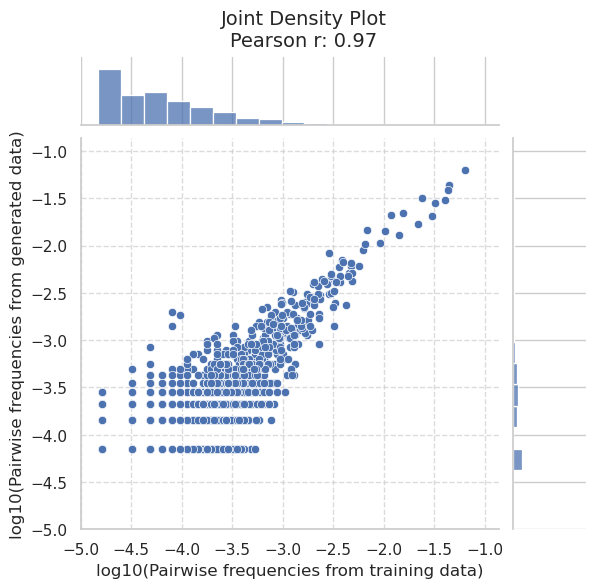

0.9715079337081323

In [212]:
intersect_and_pearson_individual(train_frequency['class_T1PKS'],syn_frequency['generated_class_T1PKS'], True)

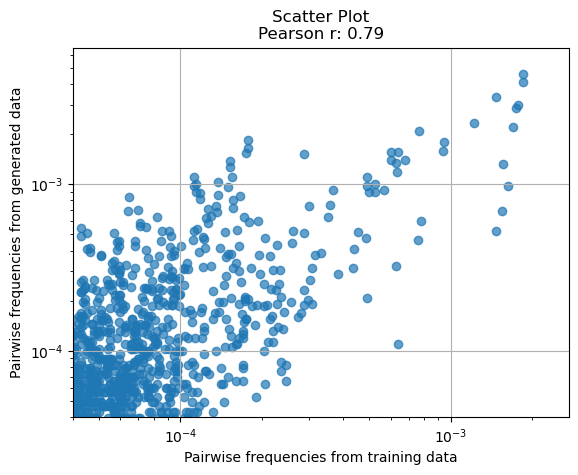

(47524, 0.7884995986240451)

In [128]:
intersect_and_pearson_pairwise(train_pairwise_frequency['class_T3PKS'],syn_pairwise_frequency['generated_class_T3PKS'], True)

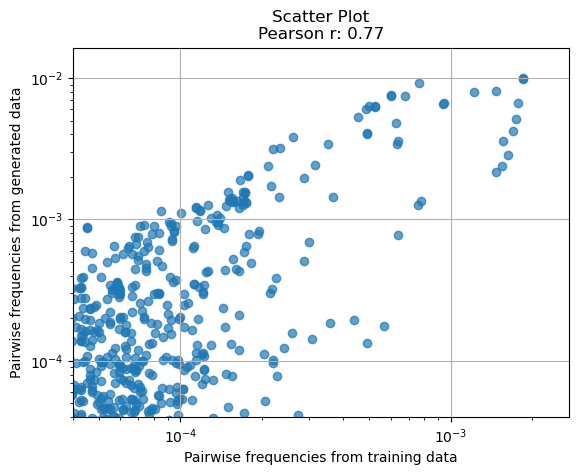

(79288, 0.7674585541917185)

In [129]:
intersect_and_pearson_pairwise(train_pairwise_frequency['class_T3PKS'],train_pairwise_frequency['class_T1PKS'], True)

In [25]:
from collections import defaultdict
import json

# Load the JSON file
with open("/blue/juannanzhou/palash.sethi/Projects/BGC_generative/data_from_bigscarp/probability_matrices/class_T1PKS_pairwise_probabilities.json", "r") as f:
    data = json.load(f)

# Convert back to defaultdict
pairwise_probabilities = defaultdict(int, {eval(k): v for k, v in data.items()})


In [125]:
dist_pairwise_prob = []
for i, (key, value) in enumerate(syn_pairwise_frequency['generated_class_T1PKS'].items()):
    dist_pairwise_prob.append(value)

In [116]:
print(np.percentile(dist_pairwise_prob, 90))

2.8921281642464374e-06
